In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential

import cv2

E:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Splitting data

In [2]:
import splitfolders


input_folder = r"C:\Users\User\Desktop\Models(FYP)\mobileNet_Try\copy" 
output_folder = r"C:\Users\User\Desktop\Models(FYP)\mobileNet_Try\dataset"


splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 1813 files [00:10, 178.38 files/s]


In [3]:
train_ds = 'dataset/train'
valid_ds = 'dataset/val'
test_ds = 'dataset/test'

# Data preprocessing

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_ds, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_ds, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_ds, target_size=(224,224), batch_size=10, shuffle=False)

Found 1447 images belonging to 7 classes.
Found 177 images belonging to 7 classes.
Found 188 images belonging to 7 classes.


In [5]:
test_batches.class_indices

{'Corynespora': 0,
 'Healthy': 1,
 'Other': 2,
 'Pesta': 3,
 'Powdery mildew': 4,
 'birds eye': 5,
 'colletorichum leaf disease': 6}

In [6]:
train_batches.class_indices

{'Corynespora': 0,
 'Healthy': 1,
 'Other': 2,
 'Pesta': 3,
 'Powdery mildew': 4,
 'birds eye': 5,
 'colletorichum leaf disease': 6}

# Importing MobileNet version 2 model

In [7]:
import tensorflow as tf


mobile_net_v2 = tf.keras.applications.MobileNetV2()

# Model summary

In [8]:
mobile_net_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

# Removing the dense last layer in the mobile_net_v2 model

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
mobile_net_v2 = MobileNetV2(weights='imagenet', include_top=True)
new_model = tf.keras.Model(inputs=mobile_net_v2.input, outputs=mobile_net_v2.layers[-2].output)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

# Add new Dense layer

In [10]:
num_classes = 7
new_last_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(new_model.output)
final_model = tf.keras.Model(inputs=new_model.input, outputs=new_last_layer)
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [11]:
final_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
import time
start_time = time.time()
history=final_model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=2
                       )
end_time = time.time()

Epoch 1/10
145/145 - 151s - loss: 0.3924 - accuracy: 0.8818 - val_loss: 0.2801 - val_accuracy: 0.8927 - 151s/epoch - 1s/step
Epoch 2/10
145/145 - 170s - loss: 0.0672 - accuracy: 0.9841 - val_loss: 0.1149 - val_accuracy: 0.9605 - 170s/epoch - 1s/step
Epoch 3/10
145/145 - 186s - loss: 0.0219 - accuracy: 0.9952 - val_loss: 0.1142 - val_accuracy: 0.9605 - 186s/epoch - 1s/step
Epoch 4/10
145/145 - 150s - loss: 0.0283 - accuracy: 0.9910 - val_loss: 0.0543 - val_accuracy: 0.9831 - 150s/epoch - 1s/step
Epoch 5/10
145/145 - 130s - loss: 0.0290 - accuracy: 0.9896 - val_loss: 0.0190 - val_accuracy: 0.9944 - 130s/epoch - 895ms/step
Epoch 6/10
145/145 - 161s - loss: 0.0193 - accuracy: 0.9972 - val_loss: 0.0063 - val_accuracy: 1.0000 - 161s/epoch - 1s/step
Epoch 7/10
145/145 - 190s - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0203 - val_accuracy: 0.9944 - 190s/epoch - 1s/step
Epoch 8/10
145/145 - 185s - loss: 0.0119 - accuracy: 0.9979 - val_loss: 0.0062 - val_accuracy: 1.0000 - 185s/epoch - 1s/st

# Save the model as h5 file

In [13]:

final_model.save('V1.0.h5')

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
scores = final_model.evaluate(test_batches)

19/19 [==============================] - 7s 385ms/step - loss: 0.0291 - accuracy: 0.9947


In [15]:
final_accuracy = history.history['accuracy'][-1]
print(f"Final Accuracy: {final_accuracy * 100:.2f}%")

Final Accuracy: 99.03%


In [16]:
scores = final_model.evaluate(train_batches)

145/145 [==============================] - 46s 313ms/step - loss: 0.0162 - accuracy: 0.9972


# Save the trained model as tflite file

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()

# Define the complete path and filename for saving the model
tflite_model_path = "C:/Users/User/Desktop/Models(FYP)/mobileNet_Try/TenserflowLite/final_model5.tflite"

# Save the TensorFlow Lite model to the specified location
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved at: {tflite_model_path}")

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmplxn_zgx8\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmplxn_zgx8\assets


TensorFlow Lite model saved at: C:/Users/User/Desktop/Models(FYP)/mobileNet_Try/TenserflowLite/final_model5.tflite


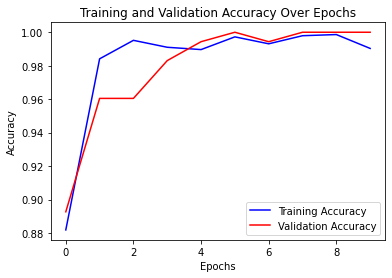

In [18]:
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')

# Plot validation accuracy with a red line and label
plt.plot(history.history['val_accuracy'], color='red', label='Validation Accuracy')

# Set axis labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set a title for the figure
plt.title('Training and Validation Accuracy Over Epochs')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

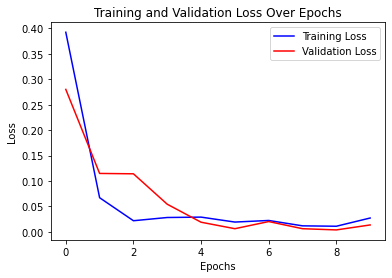

In [19]:
# Plot training loss with a blue line and label
plt.plot(history.history['loss'], color='blue', label='Training Loss')

# Plot validation loss with a red line and label
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')

# Set axis labels
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set a title for the figure
plt.title('Training and Validation Loss Over Epochs')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

In [20]:
test_labels = test_batches.classes

In [21]:
predictions = final_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [22]:
predictions

array([[9.9994469e-01, 4.3942666e-08, 3.2142584e-06, ..., 1.2641333e-05,
        1.2814234e-06, 4.5150205e-08],
       [9.9998426e-01, 2.1336571e-10, 3.2997825e-08, ..., 1.9487404e-06,
        9.5433620e-07, 5.4369740e-09],
       [9.9990857e-01, 8.7261640e-07, 3.6150550e-07, ..., 7.6245399e-08,
        2.0015407e-06, 1.4284176e-08],
       ...,
       [2.7859396e-06, 3.9310324e-09, 9.1733573e-06, ..., 6.6085842e-05,
        1.3048050e-06, 9.9991858e-01],
       [3.5793459e-05, 4.2108586e-06, 3.3313019e-04, ..., 4.6733272e-04,
        4.5188484e-05, 9.9843138e-01],
       [3.4344180e-07, 3.0174277e-08, 5.1504749e-06, ..., 1.8482900e-06,
        3.6452323e-06, 9.9993563e-01]], dtype=float32)

In [23]:
np.round(predictions)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [24]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    figure_size = (12, 10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
 
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[19  0  0  0  0  0  0]
 [ 0 29  1  0  0  0  0]
 [ 0  0 59  0  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0 22  0  0]
 [ 0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0 22]]


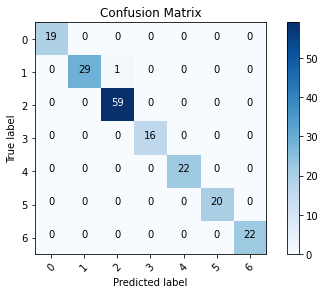

In [27]:
cm_plot_labels = ['0','1','2','3','4','5','6']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Getting predictions

In [28]:

predictions = final_model.predict(test_batches)

predicted_labels = predictions.argmax(axis=-1)

actual_labels = test_batches.classes

class_names = list(test_batches.class_indices.keys())

for i in range(len(test_batches.filenames)):
    image_filename = test_batches.filenames[i]
    predicted_class_name = class_names[predicted_labels[i]]
    actual_class_name = class_names[actual_labels[i]]
    
    
    print(f"Image: {image_filename} | Predicted: {predicted_class_name} | Actual: {actual_class_name}" )

19/19 [==============================] - 7s 354ms/step
Image: Corynespora\WhatsApp Image 2023-04-12 at 10.32.29 AM.jpeg | Predicted: Corynespora | Actual: Corynespora
Image: Corynespora\WhatsApp Image 2023-04-12 at 10.32.34 AM.jpeg | Predicted: Corynespora | Actual: Corynespora
Image: Corynespora\WhatsApp Image 2023-04-12 at 10.32.40 AM.jpeg | Predicted: Corynespora | Actual: Corynespora
Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.00 AM.jpeg | Predicted: Corynespora | Actual: Corynespora
Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.01 AM.jpeg | Predicted: Corynespora | Actual: Corynespora
Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.14 AM.jpeg | Predicted: Corynespora | Actual: Corynespora
Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.24 AM.jpeg | Predicted: Corynespora | Actual: Corynespora
Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.34 AM.jpeg | Predicted: Corynespora | Actual: Corynespora
Image: Corynespora\WhatsApp Image 2023-04-12 at 1

19/19 [==============================] - 7s 353ms/step


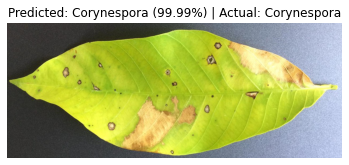

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.32.29 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.99%


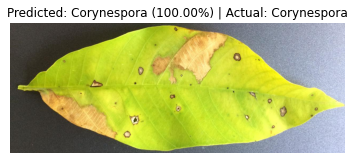

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.32.34 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 100.00%


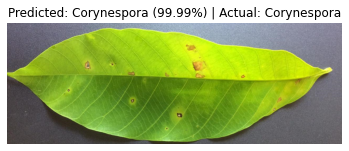

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.32.40 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.99%


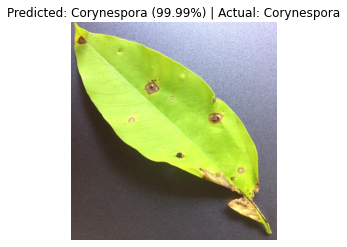

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.00 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.99%


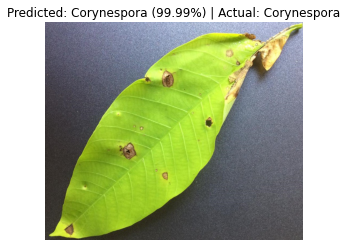

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.01 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.99%


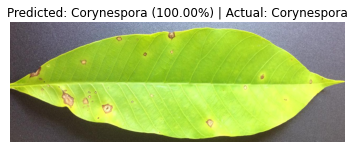

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.14 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 100.00%


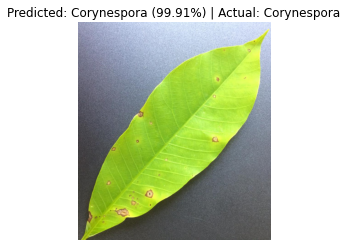

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.24 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.91%


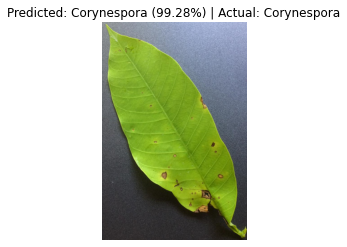

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.34.34 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.28%


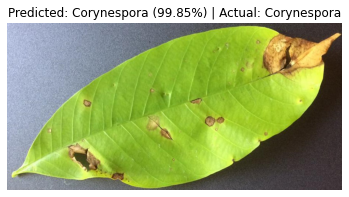

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.37.34 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.85%


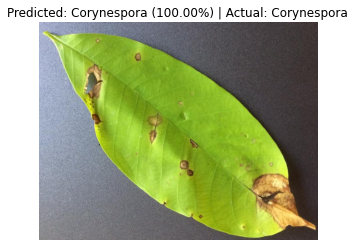

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.37.35 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 100.00%


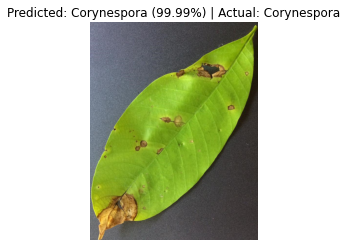

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.37.50 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.99%


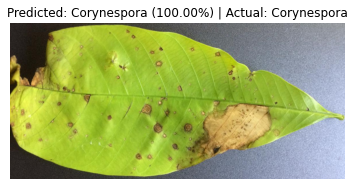

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.38.13 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 100.00%


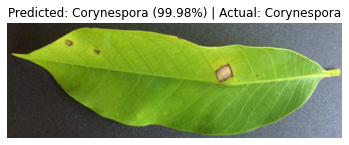

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.38.22 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.98%


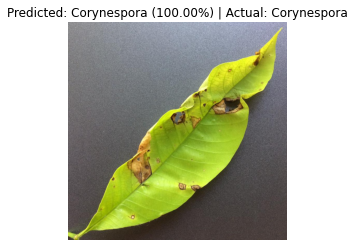

Image: Corynespora\WhatsApp Image 2023-04-12 at 10.40.30 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 100.00%


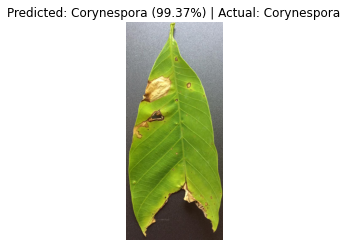

Image: Corynespora\WhatsApp Image 2023-04-12 at 11.10.10 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.37%


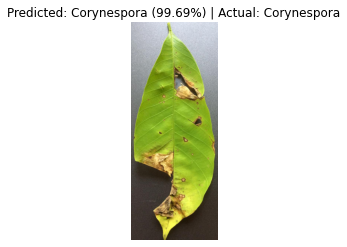

Image: Corynespora\WhatsApp Image 2023-04-12 at 11.10.59 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.69%


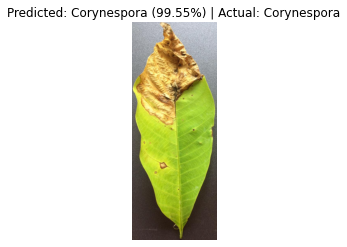

Image: Corynespora\WhatsApp Image 2023-04-12 at 11.12.17 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.55%


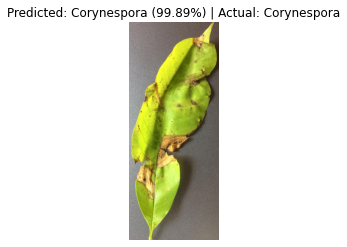

Image: Corynespora\WhatsApp Image 2023-04-12 at 11.13.06 AM.jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.89%


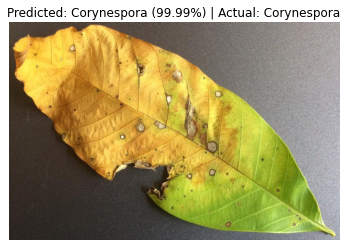

Image: Corynespora\WhatsApp Image 2023-04-12 at 11.13.26 AM (1).jpeg | Predicted: Corynespora | Actual: Corynespora | Confidence: 99.99%


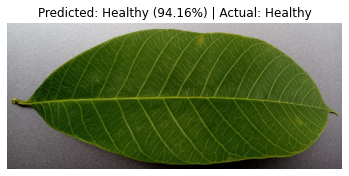

Image: Healthy\IMG_20230323_113856.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 94.16%


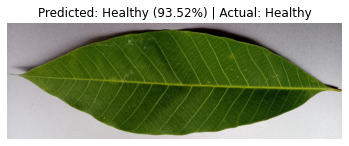

Image: Healthy\IMG_20230323_114110.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 93.52%


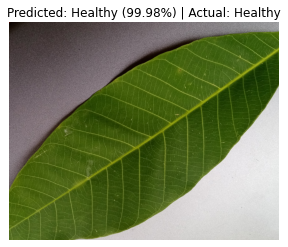

Image: Healthy\IMG_20230323_114116.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.98%


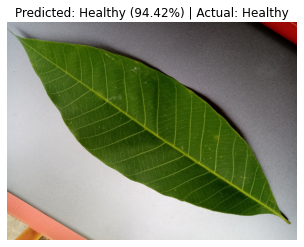

Image: Healthy\IMG_20230323_114125.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 94.42%


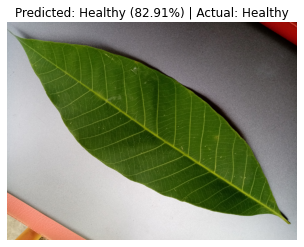

Image: Healthy\IMG_20230323_114126.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 82.91%


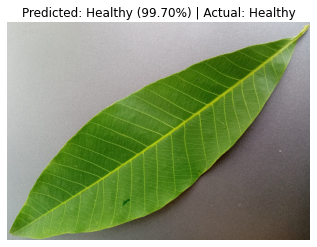

Image: Healthy\IMG_20230323_115040.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.70%


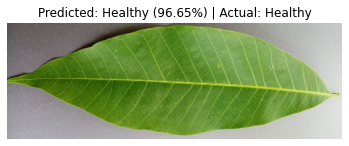

Image: Healthy\IMG_20230323_115233.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 96.65%


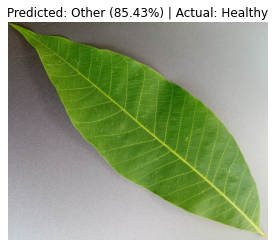

Image: Healthy\IMG_20230323_115253.jpg | Predicted: Other | Actual: Healthy | Confidence: 85.43%


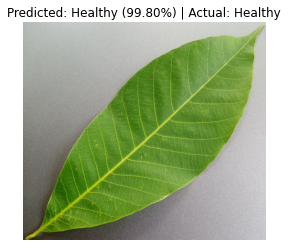

Image: Healthy\IMG_20230323_115417.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.80%


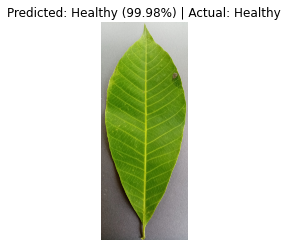

Image: Healthy\IMG_20230323_115640.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.98%


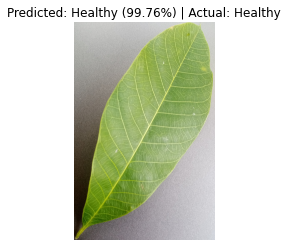

Image: Healthy\IMG_20230323_115747.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.76%


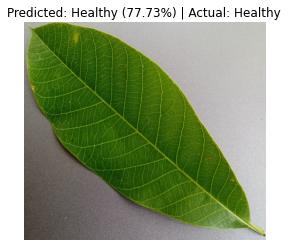

Image: Healthy\IMG_20230323_115754.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 77.73%


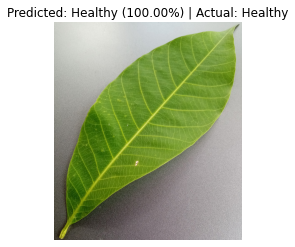

Image: Healthy\IMG_20230323_120037.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 100.00%


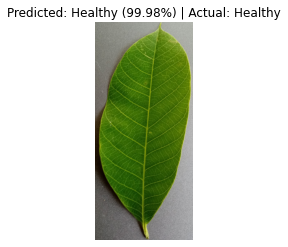

Image: Healthy\IMG_20230323_122429.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.98%


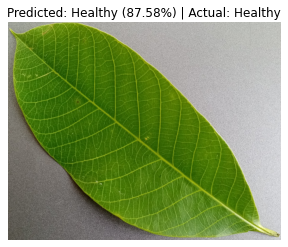

Image: Healthy\IMG_20230323_122434.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 87.58%


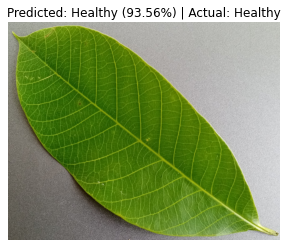

Image: Healthy\IMG_20230323_122436.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 93.56%


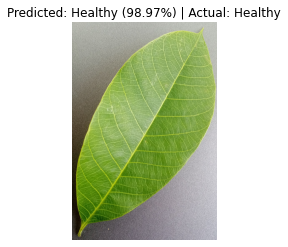

Image: Healthy\IMG_20230323_122447.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 98.97%


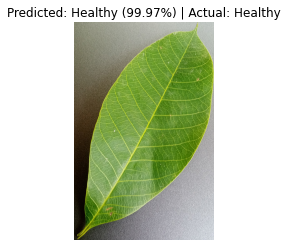

Image: Healthy\IMG_20230323_122602.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.97%


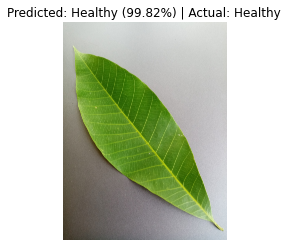

Image: Healthy\IMG_20230323_122639.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.82%


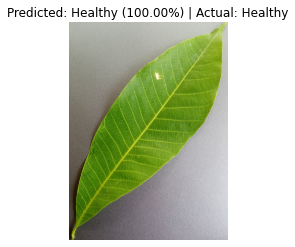

Image: Healthy\IMG_20230323_122902.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 100.00%


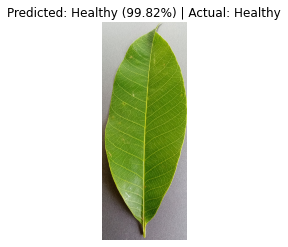

Image: Healthy\IMG_20230323_122946.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.82%


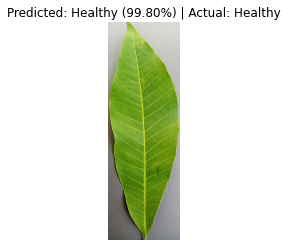

Image: Healthy\IMG_20230323_123422.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.80%


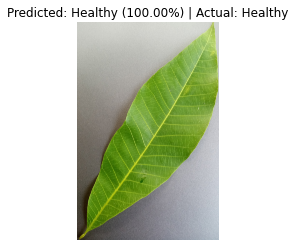

Image: Healthy\IMG_20230323_123429.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 100.00%


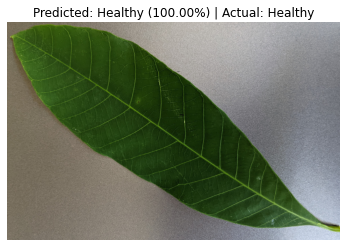

Image: Healthy\PXL_20230729_064146192.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 100.00%


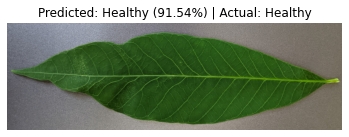

Image: Healthy\PXL_20230729_064206759.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 91.54%


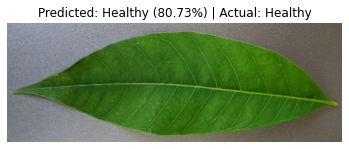

Image: Healthy\PXL_20230729_064339864.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 80.73%


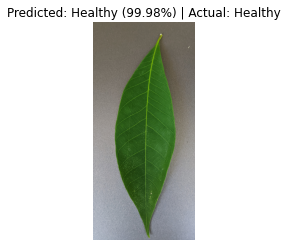

Image: Healthy\PXL_20230729_064632350.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.98%


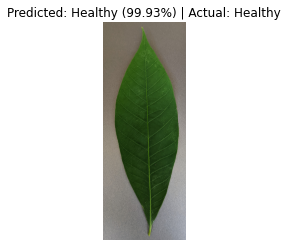

Image: Healthy\PXL_20230729_064736897.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.93%


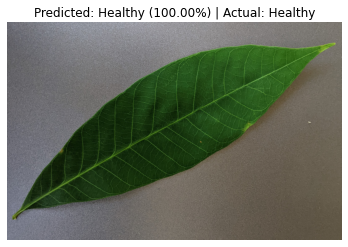

Image: Healthy\PXL_20230729_064800804.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 100.00%


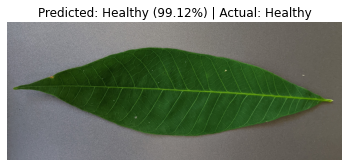

Image: Healthy\PXL_20230729_064816244.jpg | Predicted: Healthy | Actual: Healthy | Confidence: 99.12%


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/User/Desktop/FYP(M for Reports)\\MobileNet_V2/Classification_of_leaf_diseases/dataset/test/Other\\00e7c4b2-3005-4558-9cfa-235e356cb7a8___RS_Erly.B 7844.JPG'

In [29]:
from PIL import Image
import matplotlib.pyplot as plt

# Get predictions from the model
predictions = final_model.predict(test_batches)

# Convert predicted probabilities to class labels
predicted_labels = predictions.argmax(axis=-1)

# Get actual labels from the 'test_batches' object
actual_labels = test_batches.classes

# Get class names from the 'test_batches' object
class_names = list(test_batches.class_indices.keys())

# Iterate through the test batch and display image, predicted label, actual label, and confidence percentage
for i in range(len(test_batches.filenames)):
    image_filename = test_batches.filenames[i]
    predicted_class_name = class_names[predicted_labels[i]]
    actual_class_name = class_names[actual_labels[i]]
    
    # Get the confidence percentage for the predicted class
    confidence_percentage = predictions[i][predicted_labels[i]] * 100.0
    
    # Load and display the image using PIL
    image_path = "C:/Users/User/Desktop/FYP(M for Reports)\MobileNet_V2/Classification_of_leaf_diseases/dataset/test/" + image_filename  # Replace with the actual path to your test dataset
   
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class_name} ({confidence_percentage:.2f}%) | Actual: {actual_class_name}")
    plt.axis('off')
    plt.show()
    
    print(f"Image: {image_filename} | Predicted: {predicted_class_name} | Actual: {actual_class_name} | Confidence: {confidence_percentage:.2f}%")

In [30]:
scores = final_model.evaluate(test_batches)

19/19 [==============================] - 7s 353ms/step - loss: 0.0291 - accuracy: 0.9947


In [31]:
scores = final_model.evaluate(train_batches)

145/145 [==============================] - 46s 313ms/step - loss: 0.0162 - accuracy: 0.9972


In [32]:
scores = final_model.evaluate(valid_batches)

18/18 [==============================] - 6s 306ms/step - loss: 0.0136 - accuracy: 1.0000


In [33]:
training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60  # Convert to minutes

print(f"Training time: {training_time_minutes:.2f} minutes")

Training time: 28.23 minutes
